# Semi-supervised node classification via GCN, Deep Graph Infomax and fine-tuning

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/node-classification/gcn-deep-graph-infomax-fine-tuning-node-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/node-classification/gcn-deep-graph-infomax-fine-tuning-node-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

This demo demonstrates how to perform semi-supervised node classification, using [the Deep Graph Infomax algorithm](https://arxiv.org/pdf/1809.10341.pdf) and GCN on the Cora dataset. It uses very few labelled training examples, demonstrating the benefits of pre-training a model with Deep Graph Infomax for data scarce environments.

> Other related demos:
>
> - [the GCN node classification demo](gcn-node-classification.ipynb) describes the node classification task in more detail, in a supervised context
> - [the Deep Graph Infomax embeddings demo](../embeddings/deep-graph-infomax-embeddings.ipynb) describes using Deep Graph Infomax in more detail, including applying to algorithms beyond GCN.

This follows the usual StellarGraph workflow:

1. load the dataset
2. create our data generators
3. train our model

We do step 3 three times:

1. Pre-train a GCN model using Deep Graph Infomax, without any labelled data
2. Fine-tune that GCN model using the small training set
3. Train a fresh GCN model from scratch with the training set (no pre-training).

In [253]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.1.0

In [254]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.1.0")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.1.0, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [255]:
import stellargraph as sg
from stellargraph.mapper import CorruptedGenerator, FullBatchNodeGenerator
from stellargraph.layer import GCN, DeepGraphInfomax

import pandas as pd
from sklearn import model_selection, preprocessing
from IPython.display import display, HTML

import tensorflow as tf
from tensorflow.keras import Model, layers, optimizers, callbacks

## Loading the graph

(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [256]:
dataset = sg.datasets.Cora()
display(HTML(dataset.description))
G, node_classes = dataset.load()

In [257]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


## Data Generators

Now we create the data generators using `CorruptedGenerator` ([docs](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.mapper.CorruptedGenerator)). `CorruptedGenerator` returns shuffled node features along with the regular node features and we train our model to discriminate between the two. 

Note that:

- We typically pass all nodes to `corrupted_generator.flow` because this is an unsupervised task
- We don't pass `targets` to `corrupted_generator.flow` because these are binary labels (true nodes, false nodes) that are created by `CorruptedGenerator`

In [258]:
fullbatch_generator = FullBatchNodeGenerator(G)

corrupted_generator = CorruptedGenerator(fullbatch_generator)
gen = corrupted_generator.flow(G.nodes())

Using GCN (local pooling) filters...


## Model pre-training with Deep Graph Infomax

We create and train our `GCN` ([docs](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.GCN)) and `DeepGraphInfomax` ([docs](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.DeepGraphInfomax)) models. Note that the loss used here must always be `tf.nn.sigmoid_cross_entropy_with_logits`.

In [259]:
def make_gcn_model():
    # function because we want to create a second one with the same parameters later
    return GCN(
        layer_sizes=[32, 32],
        activations=["relu", "relu"],
        generator=fullbatch_generator,
        dropout=0.4,
    )


pretrained_gcn_model = make_gcn_model()

In [260]:
infomax = DeepGraphInfomax(pretrained_gcn_model, corrupted_generator)
x_in, x_out = infomax.in_out_tensors()

dgi_model = Model(inputs=x_in, outputs=x_out)
dgi_model.compile(
    loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=optimizers.Adam(lr=1e-2)
)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [261]:
epochs = 1500

In [262]:
dgi_es = callbacks.EarlyStopping(monitor="loss", patience=100, restore_best_weights=True)
dgi_history = dgi_model.fit(gen, epochs=epochs, verbose=0, callbacks=[dgi_es])

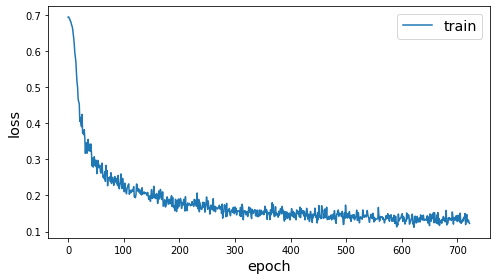

In [263]:
sg.utils.plot_history(dgi_history)

## Node classification

We've now initialised the weights of the model to capture useful properties of the graph structure and node structure. We can now further train the model to perform a node classification prediction task. To emphasise the value of the unsupervised weights, we will use a very small amount of labelled data for training.

> See [the GCN node classification demo](gcn-node-classification.ipynb) for more details on this task.

### Data preparation

The Cora dataset labels academic papers into one of 7 subjects:

In [264]:
node_classes.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


To simulate a data-poor environment, we will split the data into a train set of size 8, along with test and validation sets.

In [265]:
train_classes, test_classes = model_selection.train_test_split(
    node_classes, train_size=1000, stratify=node_classes, random_state=1
)
val_classes, test_classes = model_selection.train_test_split(
    test_classes, train_size=700, stratify=test_classes
)

The train set has only one or two observations of each class.

In [266]:
train_classes.value_counts().to_frame()

,subject
Neural_Networks,302
Probabilistic_Methods,157
Genetic_Algorithms,154
Theory,130
Case_Based,110
Reinforcement_Learning,80
Rule_Learning,67


For a categorical task, the categories need to be one hot encoded.

In [267]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_classes)
val_targets = target_encoding.transform(val_classes)
test_targets = target_encoding.transform(test_classes)

In [268]:
train_gen = fullbatch_generator.flow(train_classes.index, train_targets)
test_gen = fullbatch_generator.flow(test_classes.index, test_targets)
val_gen = fullbatch_generator.flow(val_classes.index, val_targets)

### Fine-tuning model

We now have the required pieces to finalise our GCN model for node classification:

- a GCN model with weights pre-trained with Deep Graph Infomax to capture the graph structure
- a small train set

We use the same GCN model as before but train it for a supervised categorical prediction task. See [the fully-supervised GCN node classification](gcn-node-classification.ipynb) demo for more details.

In [269]:
pretrained_x_in, pretrained_x_out = pretrained_gcn_model.in_out_tensors()

pretrained_predictions = tf.keras.layers.Dense(
    units=train_targets.shape[1], activation="softmax"
)(pretrained_x_out)

In [270]:
pretrained_model = Model(inputs=pretrained_x_in, outputs=pretrained_predictions)
pretrained_model.compile(
    optimizer=optimizers.Adam(lr=0.02), loss="categorical_crossentropy", metrics=["acc"],
)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [271]:
prediction_es = callbacks.EarlyStopping(
    monitor="val_acc", patience=100, restore_best_weights=True
)

In [272]:
pretrained_history = pretrained_model.fit(
    train_gen,
    epochs=epochs,
    verbose=0,
    validation_data=val_gen,
    callbacks=[prediction_es],
)

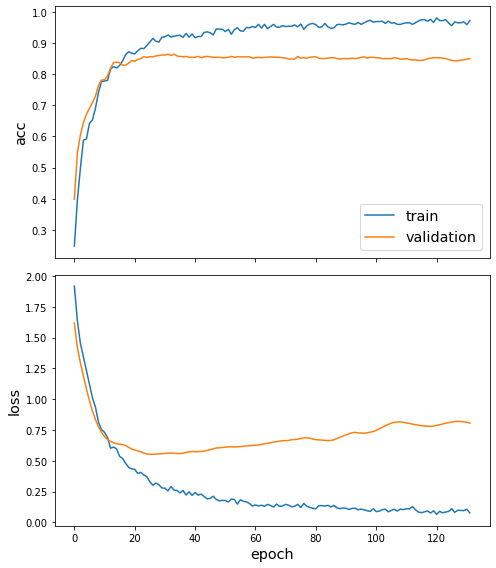

In [273]:
sg.utils.plot_history(pretrained_history)

We've now fine-tuned our model for node classification. Observe that the accuracy in the first few epochs was very poor, but it quickly improved. (The train accuracy plot is quantised because the training set is so small.)

In [274]:
pretrained_test_metrics = dict(
    zip(pretrained_model.metrics_names, pretrained_model.evaluate(test_gen))
)
print(pretrained_test_metrics)

1/1 [==============================] - 0s 68ms/step - loss: 0.5221 - acc: 0.8641
{'loss': 0.5220517516136169, 'acc': 0.8640872836112976}


## Model without Deep Graph Infomax pre-training

Let's also train an equivalent GCN model in a fully supervised manner, starting with the same model configuration and using the same 8 training examples.

In [275]:
direct_gcn_model = make_gcn_model()
direct_x_in, direct_x_out = direct_gcn_model.in_out_tensors()
direct_predictions = tf.keras.layers.Dense(
    units=train_targets.shape[1], activation="softmax"
)(direct_x_out)

In [276]:
direct_model = Model(inputs=direct_x_in, outputs=direct_predictions)
direct_model.compile(
    optimizer=optimizers.Adam(lr=0.02), loss="categorical_crossentropy", metrics=["acc"],
)

In [277]:
direct_history = direct_model.fit(
    train_gen,
    epochs=epochs,
    verbose=0,
    validation_data=val_gen,
    callbacks=[prediction_es],
)

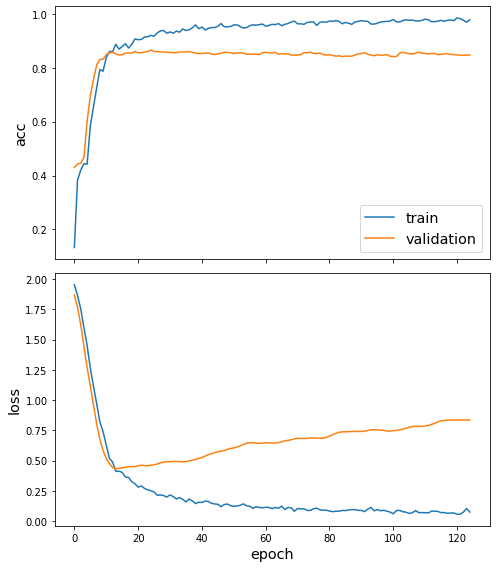

In [278]:
sg.utils.plot_history(direct_history)

In [279]:
direct_test_metrics = dict(
    zip(direct_model.metrics_names, direct_model.evaluate(test_gen))
)
print(direct_test_metrics)

1/1 [==============================] - 0s 41ms/step - loss: 0.4430 - acc: 0.8720
{'loss': 0.44296038150787354, 'acc': 0.8720238208770752}


## Comparison of model performance

The following table shows the performance of the two models, for comparison.

In [280]:
pd.DataFrame(
    [pretrained_test_metrics, direct_test_metrics],
    index=["with DGI pre-training", "without pre-training"],
).round(3)

,loss,acc
with DGI pre-training,0.522,0.864
without pre-training,0.443,0.872


## Conclusion

In this demo, we performed semi-supervised node classification on the Cora dataset. This example had extreme data scarcity: only 8 labelled training examples, with one or two from each of the 7 classes. We used Deep Graph Infomax to train a GCN model on the whole Cora graph, without labels. We then further trained this GCN model in the normal manner, to fine-tuned its weights on the small set of labelled data. The GCN model pre-trained with Deep Graph Infomax outperforms a GCN model without any such pre-training.

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/node-classification/gcn-deep-graph-infomax-fine-tuning-node-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/node-classification/gcn-deep-graph-infomax-fine-tuning-node-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>